## Imports

In [120]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# 🏆 Le Wagon Kaggle Batch Challenge

**Welcome to your first Kaggle competition!**

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

Your objective is to **submit an answer (online)** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 🏠

Fortunately, you have already come across the housing dataset earlier in the bootcamp! You will be semi-guided toward a **baseline model**, and only after creating a baseline will you be free to improve and refine it. We will approach the problem using **pipelines** (the best practice)!

A few words on Kaggle:
- Kaggle will rank your submission amongst all participants!
- Everyone is removed from the public leaderboard after 2 months
- You can make up to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- Collapse all headings from the command palette (`Cmd + Shift + P`)
- Stay  "idempotent" (`Restart & Run All` should never crash)
- Name and delete variables carefully

## Kaggle Setup

👉 Create an account on Kaggle if you want to participate in the competition

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` in the [results spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0); if you can't find your batch, reach out to your teacher!

**The whole batch will compete as a group against the team of TAs**

## Loading Data

In the challenge instructions, you should have already executed the steps to download everything you need from Kaggle into your current notebook folder:

- `train.csv` is your `(1460, 81)` training set containing `X` and `y`
- `test.csv` is your `(1459, 80)` testing set without the associated target `y` 😈
- `sample_submission.csv` describes the format required to submit your answer

ℹ️ You'll find a detailed description of the dataset [here](https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/07-Ensemble-Methods/kaggle_houses_data_description.txt). Refer to it throughout the challenge!

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your `test_score` and ranking

❓ Load the training dataset into a DataFrame called `data`, and create your `X` and `y`. Inspect their shapes.

**Hint:** if you check the CSV file, you will notice a column called `Id`. When reading the CSV file into a DF, make sure to set `index_col="Id"` so that you don't get two ID columns 😉

In [121]:
data = pd.DataFrame(pd.read_csv('data/train.csv',index_col='Id'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [122]:
y=data[['SalePrice']]
X=data.drop('SalePrice',axis=1)
(X.shape,y.shape)

((1460, 79), (1460, 1))

# 🐣 1. BASELINE

## 1.1 Initial feature overview

79 features are too much to deal with one by one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [123]:
numerical_features = X.select_dtypes(include='number')
categorical_features = X.select_dtypes(include=['object'])
(numerical_features.shape[1],"+",categorical_features.shape[1],"=",numerical_features.shape[1]+categorical_features.shape[1])

(36, '+', 43, '=', 79)

❓ Create a Series called `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total?

In [124]:
feat_categorical_nunique =  categorical_features.nunique()
feat_categorical_nunique.sum()

252

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with a maximum of ~50 features (📚 read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
1. **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model; this may require statistical analysis of feature importance
2. **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot encode) categorical features into integers; this, however, creates a notion of "order" (1 > 2 > 3 > ...) that can be detrimental if not handled properly!

❓ Plot the **histogram** of the number of unique values per categorical feature. Do you see some quick wins?

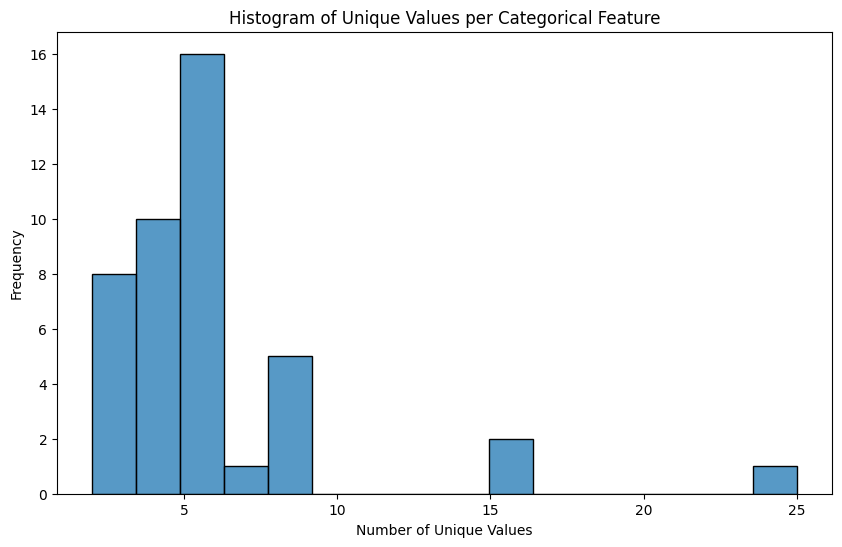

In [125]:
plt.figure(figsize=(10, 6))

sns.histplot(feat_categorical_nunique, bins=16, kde=False)

plt.title('Histogram of Unique Values per Categorical Feature')
plt.xlabel('Number of Unique Values')
plt.ylabel('Frequency');

💡 As a starting point, what about simply **removing** all features that have **7 unique values or more**, and one-hot encoding the rest? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store the names of the features to be OHE'd in a list called `feat_categorical_small` below. How many features will be OHE'd?

In [126]:
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7]

In [127]:
len(feat_categorical_small)

34

🧪 Test your code below (and clear the cell once it passed)

In [128]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'features_overview',
    n=len(feat_categorical_small)
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/almuhannad/code/Al-Muhannad/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master



## 1.2 Baseline Pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features:
- Simple-Impute with the most frequent values
- One-Hot Encode features that have less than 7 unique values to start with
- Drop all other features


As for numerical features:
- Simple-Impute with strategy `mean`
- Min-Max Scale


<details>
    <summary>ℹ️ Click here for a pro tip</summary>

If you are confident, you can try Sklearn's shorter-syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax of `Pipeline` or `ColumnTransformer`; also useful if you want to avoid giving names manually to every step.
</details>

In [129]:
feat_categorical_drop = list(set(categorical_features.columns.tolist()) - set(feat_categorical_small.index.to_list()))

In [130]:
preproc_baseline = make_column_transformer(

    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', drop='if_binary')), feat_categorical_small.index.to_list()),

    (make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler()), make_column_selector(dtype_include=['int64', 'float64'])),
    ('drop', feat_categorical_drop)
)

❓ Look at the **shape** of your preprocessed DataFrame and save it to `shape_preproc_baseline`

In [131]:
train_preprocessed = preproc_baseline.fit_transform(X)

shape_preproc_baseline = train_preprocessed.shape

shape_preproc_baseline


(1460, 179)

🧪 Test your code below

In [132]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/almuhannad/code/Al-Muhannad/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED         [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master



### b) Add Estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [133]:
pipe_baseline = make_pipeline(
    preproc_baseline,
    DecisionTreeRegressor(random_state=42),

)
pipe_baseline.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'Mas...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x309e9c4f0>),
                                                 ('drop', 'drop',
                                                  ['Exterior1st', 'Functional',
                                                   'SaleType', 'HouseStyle',
                                                   'Exterior2nd', 'Condition2',
                                                   'Neighborhood', 'Condition1',
                                                   'RoofMatl'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Which performance metric do you need? Is it readily available in Sklearn?

Sadly, it isn't! We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search. The process is described below:


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [134]:

def rmsle(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    return np.sqrt(np.mean((log_true - log_pred) ** 2))


In [135]:
# Create custom scorer for RMSLE
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [136]:
cv_scores = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle_scorer)
score_baseline=cv_scores.mean();
score_baseline

/Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [15, 20, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [32] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5] during transfo

-0.21421061774315278

### d) Predict Baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [137]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

y_pred_baseline=pipe_baseline.predict(X_test)

In [138]:
y_pred_baseline

array([129000., 155000., 193000., ..., 142500., 103200., 176000.])

❓ Finally, store your ready-to-submit CSV as `submission_baseline.csv` in the `data` folder. **Carefully read** and understand Kaggle's required format and test it below (you don't need to submit this baseline to Kaggle for now).

In [139]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,129000.0


In [140]:
# Export to Kaggle format submission in the `data` folder
results.to_csv("data/submission_baseline.csv", header=True, index=False)

🧪 Test your code

In [141]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /Users/almuhannad/code/Al-Muhannad/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 4 items

test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.09s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push o

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation on having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

Now, your goal is to improve your prediction and submit it to Kaggle **at least 30 minutes before the Recap ⏳**

We have some suggestions for improvements below: **pick your battles** and **incrementally** improve your pipeline as you see fit!

**Estimators**

- Tree-based ensembles (a must-try today); probably the best suited for problems with many categorical features
- Stacking!
- XGBoost!

**Preprocessing** (once your first ensemble model works)

- **Ordinal Encoding** of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- **Statistical Feature Selection** to remove useless features (avoids overfitting and reduces training time)
- Predict `log(SalePrice)` instead?
- 🤷

## 2.1 Preprocessing Iteration ♲ 
**⚠️ Come back here only after you have iterated on your estimators in section 2.2 ⚠️**

⏩ Collapse me if I'm not in use!

### a) Ordinal Encoding (~1h)

❓ Look at the following feature. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that! Check it out below and make sure to understand how this works 👇

In [142]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good']
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** (of your choice)
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort your features alphabetically to avoid bad surprises
</details>

In [143]:
ordinal_features = [
    'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
    'BsmtCond', 'KitchenQual', 'HeatingQC', 'GarageQual', 'GarageCond',
    'PoolQC', 'Functional', 'BsmtExposure', 'PavedDrive'
]

ordinal_categories = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Fa', 'TA', 'Gd', 'Ex'],
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    ['No', 'Mn', 'Av', 'Gd'],
    ['N', 'P', 'Y']
]

In [144]:
nominal_features = sorted( [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating',
    'CentralAir', 'Electrical', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature',
    'SaleType', 'SaleCondition'])

In [145]:
preproc_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
])

preproc_nominal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features to limit overfitting and shorten training time.  

🔥 We will make use of Sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you try **only Option 1 today**, to start with. Options 2 and 3 will be corrected in the Recap!

#### Option 1 (Recommended) - <font color=green>Univariate</font> Feature Selection
*based on their mutual information with target `y`*

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter out features that, taken individually, least explain your target!
- The statistical test we recommend passing to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) is a **statistical** distance between two probability distributions
- Correlation is a **linear** distance between two random variables
- Mutual Information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [this animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [146]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', preproc_ordinal, ordinal_features),
        ('nom', preproc_nominal, nominal_features)
    ]
)

preproc_with_feature_selection = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectPercentile(score_func=mutual_info_regression, percentile=50))
])

pipe = Pipeline(steps=[
    ('preproc_with_feature_selection', preproc_with_feature_selection),
    ('model', DecisionTreeRegressor())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

/Users/almuhannad/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preproc_with_feature_selection',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(categories=[[1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               [1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                       

#### Option 2 - <font color=green>Multivariate</font> Feature Selection
*based on their combined relationship with target `y`*

🤔 We want to remove features that do not help predict our target even when combined with all the others.

1️⃣ To do so, remember that we can use the [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove.

The best thing is that `scikit-learn` allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer; this will recursively remove the least important features according to the `cross_val_score`.

When you have many features, however, this process can take extremely long to train.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of `feature_importance` when being fitted. For instance, trees with a Gini-based `feature_importance_`, or Lasso regressions with an L1 `coef_`. `scikit-learn` already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [147]:
# YOUR CODE HERE

#### Option 3 - <font color=green>Unsupervised</font> Selection?
*filter based only on the properties of `X`*

❓ A quick win is to remove features with the lowest variance. Think about it: a feature that only has one value is useless (and has a variance of 0).

Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline!

In [148]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to visually check whether any **numerical** features almost entirely correlate with others
- Use `VIF` from `statsmodels` to check for features that have the highest multicollinearity

In [149]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again.

In [150]:
# YOUR CODE HERE

❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold; you'll need a custom transformer class.

In [151]:
# YOUR CODE HERE

### c) Treat Cyclical Features

❓ We have some time-based features, why not **transform them** into cyclical features?

🔎 If you want to know more about why and how we do this, go back to the `Preprocessing Workflow` challenge of the `Prepare the dataset` unit.

In [152]:
data['MoSold'] = pd.to_numeric(data['MoSold'])

data['sin_MoSold'] = np.sin(2 * np.pi * data['MoSold'] / 12)
data['cos_MoSold'] = np.cos(2 * np.pi * data['MoSold'] / 12)

data.drop('MoSold', axis=1, inplace=True)


### d) Target Engineering (~15min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`
- Normally distributed variables should be easier to predict with linear or parametric models
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

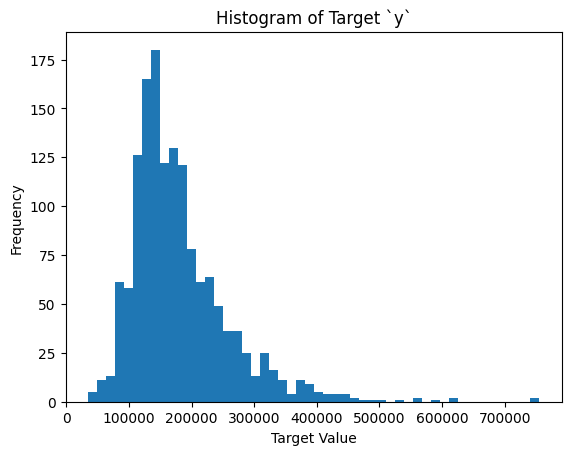

In [153]:
plt.hist(y, bins=50)
plt.title("Histogram of Target `y`")
plt.xlabel("Target Value")
plt.ylabel("Frequency");


In [154]:
y_log = np.log1p(y)

In [155]:
y_pred_log = pipe.predict(X)
y_pred = np.exp(y_pred_log)

/var/folders/yq/lgv8bnrn7gqd5ps_3fw_nqk40000gn/T/ipykernel_6564/538244104.py:2: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred_log)


In [156]:
rmsle = np.sqrt(mean_squared_log_error(np.log(y), y_pred_log))
rmsle

9.464210926647857

## 2.2 Model Iteration ♻

#### a) Final Version of the Preproc Pipeline
❓We advise you to start with a fresh definition of your preprocessing pipeline below. Copy-paste from your existing code above.

This way you can quickly update it as needed and then try many model types to find the best one possible. You can try GridSearch (this could take a lot of time) or go model by model.

You can try one or more of the different models you learned in the previous units, and today. 

👉 Your goals:

  - **Try at least one linear model**
  
  - **Try at least one of the tree-based models** you discovered in this unit.

  - Compare the **cross-validated** scores of your different models.

  - It's also interesting to **compare how long it takes** to cross-validate the different models. 🔎 Add the `%%time` magic command as the first line of a notebook cell to time the execution of the cell.

In [157]:
gboost_pipe = Pipeline(steps=[
    ('preproc_with_feature_selection', preproc_with_feature_selection),
    ('model', GradientBoostingRegressor())
])
gboost_pipe

Pipeline(steps=[('preproc_with_feature_selection',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(categories=[[1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               [1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                       

In [158]:
ensemble_pipe=Pipeline(steps=[
    ('preproc_with_feature_selection', preproc_with_feature_selection),
    ('model', RandomForestRegressor())
])
ensemble_pipe

Pipeline(steps=[('preproc_with_feature_selection',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(categories=[[1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               [1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                       

In [159]:
%%time
gboost_model = cross_val_score(gboost_pipe, X_train, y_train.values.ravel(), cv=5, scoring=rmsle_scorer)

CPU times: user 8.73 s, sys: 6.27 s, total: 15 s
Wall time: 2.61 s


In [160]:
%%time
rf_model = cross_val_score(ensemble_pipe, X_train, y_train.values.ravel(), cv=5, scoring=rmsle_scorer)

CPU times: user 12.7 s, sys: 6.86 s, total: 19.5 s
Wall time: 6.07 s


In [161]:
print(f'Gradient Boosting CV R^2: {gboost_model.mean():.2f}')
print(f'Random Forest CV R^2: {rf_model.mean():.2f}')

Gradient Boosting CV R^2: -0.18
Random Forest CV R^2: -0.19


### After Grid search and find best tuning

In [162]:
gbr_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.8, 1.0]
}

rf_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}


In [163]:
#gbr_grid_search = GridSearchCV(estimator=gboost_pipe,param_grid=gbr_param_grid,cv=5,scoring='r2',n_jobs=-1)
#rf_reg_grid_search = GridSearchCV(estimator=ensemble_pipe,param_grid=rf_param_grid,cv=5,scoring='r2',n_jobs=-1)

In [164]:
#%%time
#gbr_grid_search.fit(X_train, y_train.values.ravel())

In [165]:
#%%time
#rf_reg_grid_search.fit(X_train, y_train.values.ravel())

In [166]:

#print(f"Best Gradient Boosting Parameters: {gbr_grid_search.best_params_}")
#print(f"Best Gradient Boosting R²: {gbr_grid_search.best_score_:.4f}")


#print(f"Best Random Forest Parameters: {rf_reg_grid_search.best_params_}")
#print(f"Best Random Forest R²: {rf_reg_grid_search.best_score_:.4f}")


#gbr_best_model = gbr_grid_search.best_estimator_
#rf_reg_best_model = rf_reg_grid_search.best_estimator_


#gbr_test_score = gbr_best_model.score(X_test, y_test)
#rf_reg_test_score = rf_reg_best_model.score(X_test, y_test)

#print(f"Gradient Boosting Test R²: {gbr_test_score:.4f}")
#print(f"Random Forest Test R²: {rf_reg_test_score:.4f}")

### Piplines after Hyper-parameter Tuning

In [167]:
tuned_gboost_pipe = Pipeline(steps=[
    ('preproc_with_feature_selection', preproc_with_feature_selection),
    ('model', GradientBoostingRegressor(learning_rate= 0.1, max_depth= 3, min_samples_leaf= 4, min_samples_split= 2, n_estimators= 500, subsample= 0.8))
])
tuned_gboost_pipe

Pipeline(steps=[('preproc_with_feature_selection',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(categories=[[1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               [1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                       

In [168]:
tuned_ensemble_pipe=Pipeline(steps=[
    ('preproc_with_feature_selection', preproc_with_feature_selection),
    ('model', RandomForestRegressor(bootstrap= True, max_depth= None, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200))
])
tuned_ensemble_pipe

Pipeline(steps=[('preproc_with_feature_selection',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(categories=[[1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               [1,
                                                                                                                2,
                                                                                                                3,
                                                                                                                4,
                                                                                                                5,
                                                                                                                6,
                                                                                                                7,
                                                                                                                8,
                                                                                                                9,
                                                                                                                10],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                                                                                                               ['Po',
                                                                                                                'Fa',
                                                                                                                'TA',
                                                                                                                'Gd',
                                                                                                                'Ex'],
                       

In [169]:
%%time
tuned_gboost_model = cross_val_score(tuned_gboost_pipe, X_train, y_train.values.ravel(), cv=5, scoring='r2')

CPU times: user 12 s, sys: 7 s, total: 19 s
Wall time: 4.19 s


In [170]:
%%time
tuned_rf_model = cross_val_score(tuned_ensemble_pipe, X_train, y_train.values.ravel(), cv=5, scoring='r2')

CPU times: user 16 s, sys: 6.49 s, total: 22.5 s
Wall time: 7.07 s


In [171]:
print(f'Gradient Boosting CV R^2: {tuned_gboost_model.mean():.2f}')
print(f'Random Forest CV R^2: {tuned_rf_model.mean():.2f}')

Gradient Boosting CV R^2: 0.80
Random Forest CV R^2: 0.76


# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

It is time to discover your real test score by submitting to Kaggle! 

👉 Follow and complete the next steps to see how good your model is!

In [172]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

If you ran the optional cyclical feature treatment in 2.1, you will need to run the following cell to add the extra columns before you feed X_test into your pipeline.

In [173]:
# If needed, add cyclical feature columns to X_test like we did to X
if 'months_in_a_year' in locals():
    # months_in_a_year is defined, so we need to add the cyclical features
    X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
    X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

    X_test.drop(columns=['MoSold'], inplace=True)

👉 Predict using your best estimator, and store the results in `predictions`.

In [174]:
tuned_gboost_pipe.fit(X_train,y_train.values.ravel())
predictions= tuned_gboost_pipe.predict(X_test)
predictions

array([121938.52431565, 167685.78427858, 159785.53764462, ...,
       135816.83099932, 134177.81826953, 210951.84797101])

👉 Run the following cells to prepare your predictions to submit to Kaggle.

In [175]:
# Create a DataFrame in the correct format
results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,121938.524316
1,1462,167685.784279
2,1463,159785.537645
3,1464,178885.751286
4,1465,188665.786264
...,...,...
1454,2915,104656.099753
1455,2916,84794.197818
1456,2917,135816.830999
1457,2918,134177.818270


In [176]:
# Export to Kaggle format submission
results.to_csv("submission_final.csv", header=True, index=False)

👉 Go to Kaggle and submit your predictions. What is your test score? Compare it to the validation scores you obtained.

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)